<a href="https://colab.research.google.com/github/liirusuk/llm_train/blob/main/Week_3_practice_Linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to ML from an LLM standpoint

# Week 3

In [ ]:
!pip install -q dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 9.7 MB/s eta 0:00:00


# Precision-recall call demo

In [ ]:
!pip install -q dash

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

# Create dataset and train model
random_state = 42
n_samples = 200
X, y = make_moons(n_samples=n_samples, noise=0.35, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

# Calculate grid for decision boundary
x_min, x_max = -1.5, 2.5
y_min, y_max = -1.5, 2.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Get probabilities
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Calculate PR curve
y_scores = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Create Dash app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Graph(id='classification-plot'),
    dcc.Slider(
        id='threshold-slider',
        min=0,
        max=1,
        step=0.01,
        value=0.5,
        marks={i/10: str(i/10) for i in range(11)}
    )
])

@app.callback(
    Output('classification-plot', 'figure'),
    Input('threshold-slider', 'value')
)
def update_figure(threshold):
    # Create figure
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Classification Boundary', 'Precision-Recall Curve'))

    # Add classification boundary heatmap
    fig.add_trace(
        go.Heatmap(
            x=np.linspace(x_min, x_max, Z.shape[1]),
            y=np.linspace(y_min, y_max, Z.shape[0]),
            z=(Z > threshold).astype(float),
            colorscale=[[0, 'red'], [1, 'green']],
            opacity=0.3,
            showscale=False
        ),
        row=1, col=1
    )

    # Add scatter plot for test data
    fig.add_trace(
        go.Scatter(
            x=X_test[y_test==0, 0],
            y=X_test[y_test==0, 1],
            mode='markers',
            marker=dict(color='red', size=8),
            name='Class 0'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=X_test[y_test==1, 0],
            y=X_test[y_test==1, 1],
            mode='markers',
            marker=dict(color='green', size=8),
            name='Class 1'
        ),
        row=1, col=1
    )

    # Add PR curve
    fig.add_trace(
        go.Scatter(
            x=recall,
            y=precision,
            mode='lines',
            name='PR curve'
        ),
        row=1, col=2
    )

    # Add current point on PR curve
    idx = np.searchsorted(thresholds, threshold)
    if idx == len(thresholds):
        idx = -1
    fig.add_trace(
        go.Scatter(
            x=[recall[idx]],
            y=[precision[idx]],
            mode='markers',
            marker=dict(color='red', size=15),
            name='Current threshold'
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=600,
        width=1200,
        showlegend=True,
        title_text=f"Classification with Threshold: {threshold:.2f}"
    )

    # Update axes
    fig.update_xaxes(title_text="Feature 1", range=[x_min, x_max], row=1, col=1)
    fig.update_yaxes(title_text="Feature 2", range=[y_min, y_max], row=1, col=1)
    fig.update_xaxes(title_text="Recall", range=[0, 1], row=1, col=2)
    fig.update_yaxes(title_text="Precision", range=[0, 1], row=1, col=2)

    return fig

if __name__ == '__main__':
    app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# Metric vs loss demo

In [ ]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

# Create dataset
random_state = 52
n_samples = 50
X, y = make_moons(n_samples=n_samples, noise=0.25, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train the original model to get the weights
clf = LogisticRegression()
clf.fit(X_train, y_train)
original_weights = clf.coef_[0]

# Create a range of bias terms
bias_range = np.linspace(-5, 5, 200)

# Calculate accuracies for different bias terms
accuracies = []
for bias in bias_range:
    # Create prediction using original weights but modified bias
    logits = X_test @ original_weights + bias
    y_pred = (logits > 0).astype(int)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Create Dash app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Graph(id='classification-plot'),
    dcc.Slider(
        id='bias-slider',
        min=-5,
        max=5,
        step=0.1,
        value=0,
        marks={i: f'{i}' for i in range(-5, 6)}
    )
])

@app.callback(
    Output('classification-plot', 'figure'),
    Input('bias-slider', 'value')
)
def update_figure(bias):
    # Create figure with subplots
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Decision Boundary', 'Accuracy vs Bias'),
                        column_widths=[0.5, 0.5])

    # First subplot: Decision boundary and scatter plot
    # Calculate the decision boundary line points
    x_range = np.array([X[:, 0].min() - 0.5, X[:, 0].max() + 0.5])
    # Using the original weights but modified bias
    y_range = -(original_weights[0] * x_range + bias) / original_weights[1]

    # Add decision line
    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_range,
            mode='lines',
            name='Decision Boundary',
            line=dict(color='black', dash='dash')
        ),
        row=1, col=1
    )

    # Add scatter plot points
    fig.add_trace(
        go.Scatter(
            x=X_train[y_train==0, 0],
            y=X_train[y_train==0, 1],
            mode='markers',
            name='Class 0',
            marker=dict(color='blue')
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=X_train[y_train==1, 0],
            y=X_train[y_train==1, 1],
            mode='markers',
            name='Class 1',
            marker=dict(color='red')
        ),
        row=1, col=1
    )

    # Second subplot: Accuracy vs Bias
    fig.add_trace(
        go.Scatter(
            x=bias_range,
            y=accuracies,
            mode='lines',
            name='Accuracy',
            line=dict(color='blue')
        ),
        row=1, col=2
    )

    # Add current point
    current_accuracy = accuracies[np.abs(bias_range - bias).argmin()]
    fig.add_trace(
        go.Scatter(
            x=[bias],
            y=[current_accuracy],
            mode='markers',
            marker=dict(color='red', size=15),
            name='Current Bias',
            showlegend=False
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=600,
        width=1200,
        title_text=f"Impact of Bias Term (Current Accuracy: {current_accuracy:.3f})",
        showlegend=True
    )

    # Update axes
    fig.update_xaxes(title_text="Feature 1", range=[X[:, 0].min() - 0.5, X[:, 0].max() + 0.5], row=1, col=1)
    fig.update_yaxes(title_text="Feature 2", range=[X[:, 1].min() - 0.5, X[:, 1].max() + 0.5], row=1, col=1)
    fig.update_xaxes(title_text="Bias Term", range=[-5, 5], row=1, col=2)
    fig.update_yaxes(title_text="Accuracy", range=[0, 1], row=1, col=2)

    return fig

if __name__ == '__main__':
    app.run_server(mode='inline')

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from scipy.special import expit  # for stable sigmoid

# Create dataset
random_state = 52
n_samples = 200
X, y = make_moons(n_samples=n_samples, noise=0.25, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train the original model to get the weights
clf = LogisticRegression()
clf.fit(X_train, y_train)
original_weights = clf.coef_[0]

# Create a range of bias terms
bias_range = np.linspace(-5, 5, 200)

# Calculate log loss for different bias terms
def compute_log_loss(y_true, logits):
    y_pred_proba = expit(logits)
    eps = 1e-15
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))

# Precompute losses
losses = []
logits_train = X_train @ original_weights
for bias in bias_range:
    loss = compute_log_loss(y_train, logits_train + bias)
    losses.append(loss)

# Create Dash app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Graph(id='classification-plot'),
    dcc.Slider(
        id='bias-slider',
        min=-5,
        max=5,
        step=0.1,
        value=0,
        marks={i: f'{i}' for i in range(-5, 6)}
    )
])

@app.callback(
    Output('classification-plot', 'figure'),
    Input('bias-slider', 'value')
)
def update_figure(bias):
    # Create figure with subplots
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Decision Boundary', 'Log Loss vs Bias'),
                        column_widths=[0.5, 0.5])

    # Calculate meshgrid for probability visualization
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # First subplot: Decision boundary and scatter plot
    # Calculate the decision boundary line points
    x_range = np.array([x_min, x_max])
    y_range = -(original_weights[0] * x_range + bias) / original_weights[1]

    # Add decision line
    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_range,
            mode='lines',
            name='Decision Boundary',
            line=dict(color='black', dash='dash')
        ),
        row=1, col=1
    )

    # Add scatter plot points for training data
    fig.add_trace(
        go.Scatter(
            x=X_train[y_train==0, 0],
            y=X_train[y_train==0, 1],
            mode='markers',
            name='Train Class 0',
            marker=dict(color='blue')
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=X_train[y_train==1, 0],
            y=X_train[y_train==1, 1],
            mode='markers',
            name='Train Class 1',
            marker=dict(color='red')
        ),
        row=1, col=1
    )

    """
    # Add scatter plot points for test data
    fig.add_trace(
        go.Scatter(
            x=X_test[y_test==0, 0],
            y=X_test[y_test==0, 1],
            mode='markers',
            name='Test Class 0',
            marker=dict(color='lightblue', symbol='x', size=12)
        ),
        row=1, col=1
    )"""

    """
    fig.add_trace(
        go.Scatter(
            x=X_test[y_test==1, 0],
            y=X_test[y_test==1, 1],
            mode='markers',
            name='Test Class 1',
            marker=dict(color='pink', symbol='x', size=12)
        ),
        row=1, col=1
    )
    """

    # Second subplot: Log Loss vs Bias
    fig.add_trace(
        go.Scatter(
            x=bias_range,
            y=losses,
            mode='lines',
            name='Log Loss',
            line=dict(color='blue')
        ),
        row=1, col=2
    )

    # Add current point
    current_loss = losses[np.abs(bias_range - bias).argmin()]
    fig.add_trace(
        go.Scatter(
            x=[bias],
            y=[current_loss],
            mode='markers',
            marker=dict(color='red', size=15),
            name='Current Bias',
            showlegend=False
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=600,
        width=1200,
        title_text=f"Impact of Bias Term (Current Log Loss: {current_loss:.3f})",
        showlegend=True
    )

    # Update axes
    fig.update_xaxes(title_text="Feature 1", range=[x_min, x_max], row=1, col=1)
    fig.update_yaxes(title_text="Feature 2", range=[y_min, y_max], row=1, col=1)
    fig.update_xaxes(title_text="Bias Term", range=[-5, 5], row=1, col=2)

    # Set y-axis range for log loss to focus on relevant values
    max_visible_loss = min(max(losses), 2)  # Cap at 2 for better visualization
    fig.update_yaxes(title_text="Log Loss", range=[0, max_visible_loss], row=1, col=2)

    return fig

if __name__ == '__main__':
    app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# Linear classification demo

In this week's practice session, we'll learn:

- How to apply linear models;
- How to effectively use the fit-predict interface in scikit-learn;
- How to perform basic feature engineering, including handling categorical variables and missing values;
- How to visualize decision boundaries and validate model probability predictions.

In [ ]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

# Dataset Overview
We’ll be using a weather dataset that comprises about 10 years of daily weather observations from various locations across Australia. You can either [download it from Kaggle](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) or use the google drive download below

Our target variable, `RainTomorrow`, indicates whether it will rain the following day (Yes or No).

Let's investigate the data.

In [ ]:
!gdown 1oDLRJgsOl_s_5FTbmL0XASp0-glW697E # weatherAUS.csv
!gdown 1bdQnDfhJ7VECcb8GFvFFozodXa1FVDVU # coords.csv (we'll need this later on)

Downloading...
From: https://drive.google.com/uc?id=1oDLRJgsOl_s_5FTbmL0XASp0-glW697E
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bdQnDfhJ7VECcb8GFvFFozodXa1FVDVU
To: /content/coords.csv
100% 1.45k/1.45k [00:00<00:00, 3.85MB/s]


In [ ]:
import pandas as pd

df = pd.read_csv('weatherAUS.csv')

In [ ]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Feature types

Let's take a high-level look at the categorical variables

In [ ]:
categorical_features = df.select_dtypes(include=['object']).columns
print("Categorical features:")
for feature in categorical_features.tolist():
    print(f"- {feature}")

Categorical features:
- Date
- Location
- WindGustDir
- WindDir9am
- WindDir3pm
- RainToday
- RainTomorrow


In [ ]:
df[categorical_features].head()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No


Summary of categorical variables:
- The dataset includes a Date variable, recorded in the Date column
- There are 6 categorical variables: Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, and RainTomorrow
- RainToday and RainTomorrow are binary categorical variables
- The target variable is RainTomorrow, which indicates whether it will rain the next day.

In [ ]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
df[numeric_features].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7


Summary of numerical variables:
- The dataset contains 16 numerical variables
- These include: MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, and Temp3pm.

We'll process categorical and numerical features separately in later sections. For now, let's focus on examining the date and target variables. And we'll start by dealing with **missing values** in the target.

In [ ]:
missing_count = df['RainTomorrow'].isnull().sum()
missing_percentage = (missing_count / len(df)) * 100

print(f"Missing values in target variable: {missing_count} ({missing_percentage:.2f}%)")

Missing values in target variable: 3267 (2.25%)



The number of missing values is minimal, so we can simply drop these rows without significantly impacting the dataset.

In [ ]:
df = df.dropna(subset=['RainTomorrow'])

In [ ]:
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

Let's also check if the classes are balanced or not.

In [ ]:
print(f"Positive example: {sum(df['RainTomorrow'] == 1)}")
print(f"Negative example: {sum(df['RainTomorrow'] == 0)}")

Positive example: 31877
Negative example: 110316


The data is imbalanced, as we see. We'll need to address it at some point.

We can see that there is a Date variable which needs to be preprocessed.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace = True)

# Splitting the Data

To ensure our preprocessing steps don’t introduce data leakage, we'll first split our dataset into training and test sets. This way, all transformations, such as filling missing values or encoding categorical variables, will be based only on the training data, and then applied to the test data.

Note three things:

- We set the random state; otherwise our results would change from session to session.
- We perform a **stratified** split, which means that the proportion of classes 1 and 0 in both splits will be the same. This is especially important when the classes are imbalanced.
- We actually create three splits: **train**, **validation**, and **test**. We'll need the validation data for checking the intermediate design choices, and the test set will be used only for final assessment. Luckily, we have enough data for that.

The `test_size` parameter is also important. It indicates the (test/all_data) ratio. Popular values are around 0.3. In any case, there should be enough test examples to faithfully evaluate accuracy. 50 examples would probably allow you to justify the integer part of the accuracy percentage. You'll need 500 to write accuracy like 91.1%, with one decimal digit. In our case we have plenty of data (100k examples), so taking 0.2 is ok.

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
    )

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (85315, 24)
Validation set shape: (28439, 24)
Test set shape: (28439, 24)


# Numerical Features

Now let's move on to the numerical features. We’ll identify which ones are numerical so we can handle missing values and prepare them for our model

In [ ]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
print("Numerical features:")
for numerical_feature in numeric_features.tolist():
    print(f"- {numerical_feature}")

Numerical features:
- MinTemp
- MaxTemp
- Rainfall
- Evaporation
- Sunshine
- WindGustSpeed
- WindSpeed9am
- WindSpeed3pm
- Humidity9am
- Humidity3pm
- Pressure9am
- Pressure3pm
- Cloud9am
- Cloud3pm
- Temp9am
- Temp3pm


### Checking for missing values

Like we did with the target, we'll check for missing values in the numerical features. Knowing where these gaps are will help us decide how to fill them

In [ ]:
missing_numeric = X_train[numeric_features].isnull().sum()
missing_numeric = missing_numeric[missing_numeric > 0]
print("Missing values in numerical features:\n", missing_numeric)

Missing values in numerical features:
 MinTemp            389
MaxTemp            186
Rainfall           837
Evaporation      36453
Sunshine         40634
WindGustSpeed     5563
WindSpeed9am       775
WindSpeed3pm      1556
Humidity9am       1076
Humidity3pm       2170
Pressure9am       8466
Pressure3pm       8441
Cloud9am         32087
Cloud3pm         34129
Temp9am            546
Temp3pm           1631
dtype: int64


In [ ]:
missing_numeric_percentage = (missing_numeric / len(X_train))
print(f"""Percentage of missing values in numerical features:
    {np.round(missing_numeric_percentage*100,1)}""")

Percentage of missing values in numerical features:
    MinTemp           0.5
MaxTemp           0.2
Rainfall          1.0
Evaporation      42.7
Sunshine         47.6
WindGustSpeed     6.5
WindSpeed9am      0.9
WindSpeed3pm      1.8
Humidity9am       1.3
Humidity3pm       2.5
Pressure9am       9.9
Pressure3pm       9.9
Cloud9am         37.6
Cloud3pm         40.0
Temp9am           0.6
Temp3pm           1.9
dtype: float64


There are several simple ways of dealing with missing values:
- If a feature has few missing values, we may consider discarding the corresponding objects.
- If a feature has too many missing values, we may consider discarding this feature.
- We can replace the missing values by something appropriate, for example, the average, or the median, or the most frequent value, or zero.
- We can also add a special binary feature to indicate that a particular feature is missing for the object.

The Sunshine and Evaporation features have a lot of missing values, so it’s a good idea to add a binary variable to flag whether data is missing

In [ ]:
X_train['Sunshine_missing'] = X_train['Sunshine'].isnull().astype(int)
X_val['Sunshine_missing'] = X_val['Sunshine'].isnull().astype(int)
X_test['Sunshine_missing'] = X_test['Sunshine'].isnull().astype(int)

X_train['Evaporation_missing'] = X_train['Evaporation'].isnull().astype(int)
X_val['Evaporation_missing'] = X_val['Evaporation'].isnull().astype(int)
X_test['Evaporation_missing'] = X_test['Evaporation'].isnull().astype(int)

For numerical features, a good approach to handle missing values is to fill them with the median. This is less sensitive to outliers than the mean, so it helps keep the data distribution stable

In [ ]:
for feature in missing_numeric.index:
    median_value = X_train[feature].median()
    X_train[feature].fillna(median_value, inplace=True)
    X_val[feature].fillna(median_value, inplace=True)
    X_test[feature].fillna(median_value, inplace=True)

We could also fill in missing values with the mean, but that’s more affected by outliers. Another option is using more complex methods, like regression imputation, if we want to predict the missing values based on other features.

### Checking for outliers

In [ ]:
round(X_train[numeric_features].describe()),2

(       MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
 count  85315.0  85315.0   85315.0      85315.0   85315.0        85315.0   
 mean      12.0     23.0       2.0          5.0       8.0           40.0   
 std        6.0      7.0       9.0          3.0       3.0           13.0   
 min       -8.0     -5.0       0.0          0.0       0.0            6.0   
 25%        8.0     18.0       0.0          4.0       8.0           31.0   
 50%       12.0     23.0       0.0          5.0       8.0           39.0   
 75%       17.0     28.0       1.0          5.0       9.0           46.0   
 max       31.0     48.0     371.0        145.0      14.0          135.0   
 
        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
 count       85315.0       85315.0      85315.0      85315.0      85315.0   
 mean           14.0          19.0         69.0         51.0       1018.0   
 std             9.0           9.0         19.0         21.0          7.0   
 min  

On closer inspection, we can see that the Rainfall, Evaporation, WindSpeed9am and WindSpeed3pm columns may contain outliers.

Text(0, 0.5, 'WindSpeed3pm')

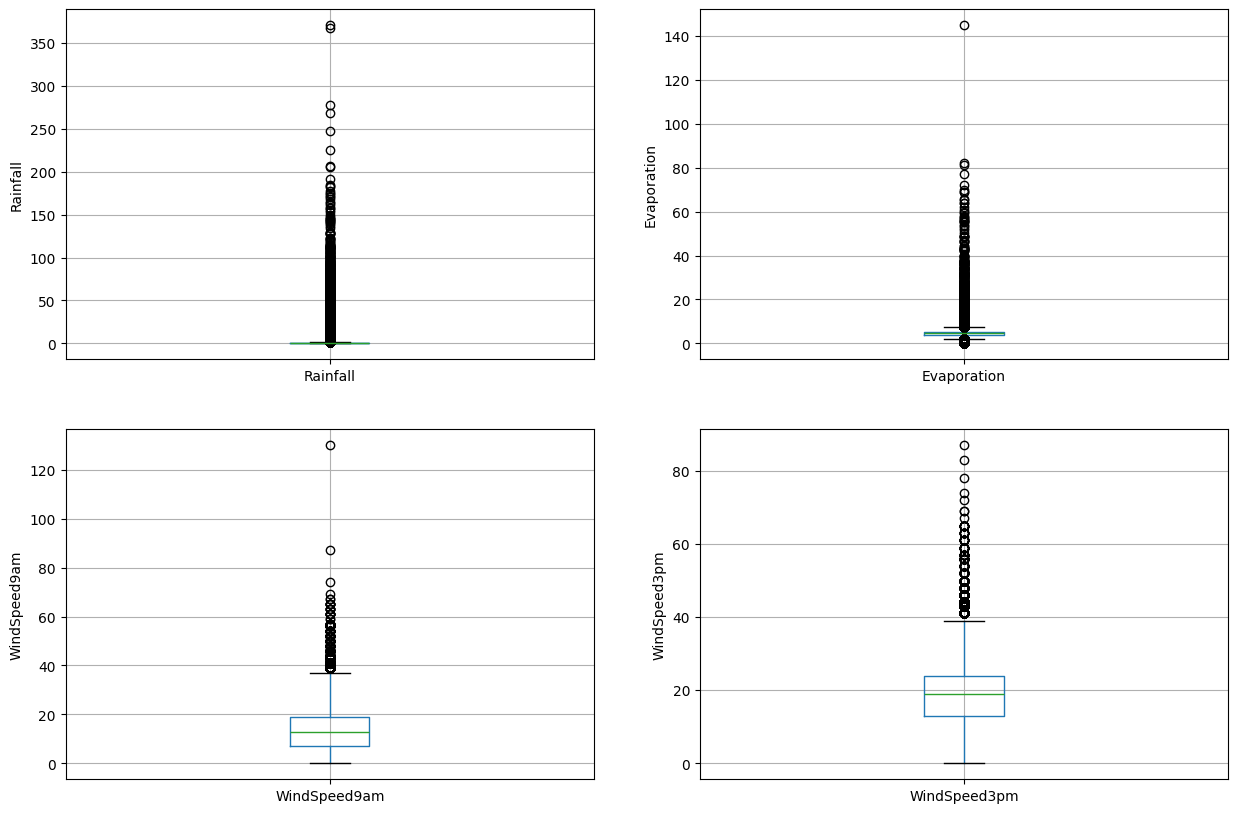

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = X_train.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(2, 2, 2)
fig = X_train.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation')


plt.subplot(2, 2, 3)
fig = X_train.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')


plt.subplot(2, 2, 4)
fig = X_train.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

The above boxplots confirm that there are lot of outliers in these variables.

Text(0, 0.5, 'RainTomorrow')

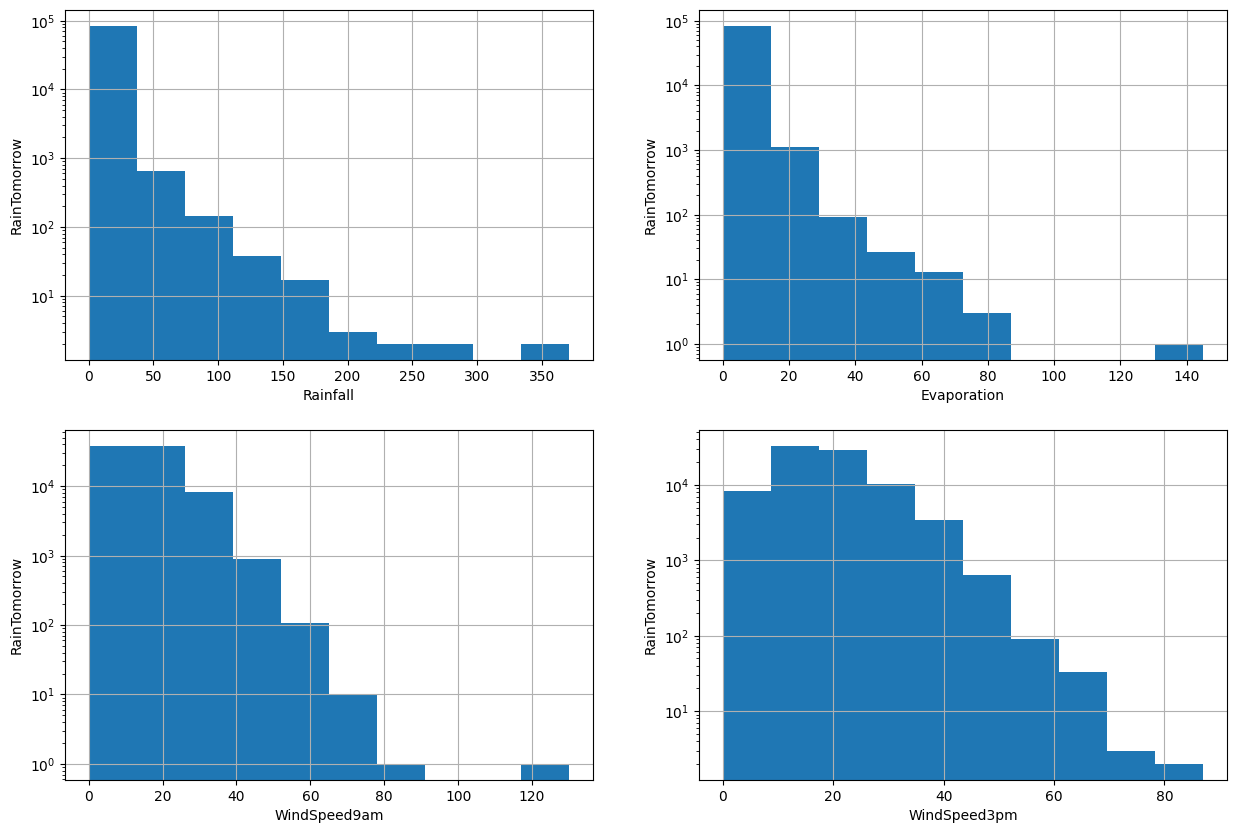

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
fig = X_train.Rainfall.hist(bins=10, log=True)
fig.set_xlabel('Rainfall')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 2)
fig = X_train.Evaporation.hist(bins=10, log=True)
fig.set_xlabel('Evaporation')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 3)
fig = X_train.WindSpeed9am.hist(bins=10, log=True)
fig.set_xlabel('WindSpeed9am')
fig.set_ylabel('RainTomorrow')


plt.subplot(2, 2, 4)
fig = X_train.WindSpeed3pm.hist(bins=10, log=True)
fig.set_xlabel('WindSpeed3pm')
fig.set_ylabel('RainTomorrow')

Outliers can distort analysis and model performance. One approach is **clipping**, which caps extreme values within a defined range, preserving the dataset size. Another option is to **remove** outliers entirely by defining thresholds, which can reduce noise and improve model accuracy. The choice depends on the context and the importance of retaining data.

In [ ]:
outlier_features = ['Rainfall', 'Evaporation', 'WindSpeed9am', 'WindSpeed3pm']

def handle_outliers(data, features, method='clip'):
    '''
    This function does the following for each feature:
    1. Take 25% and 75% quantiles q_25 and q_75, that is points such that:
        - 25% data has values less than q_25
        - 75% data has values less than q_75
    2. Then, we take Intraquantale Range, the distance between q_25 and q_75
    3. After that, we set lower bound and upper bound of "normal values" of the feature
    '''

    data = data.copy()
    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'clip':
            data[feature] = np.clip(data[feature], lower_bound, upper_bound)
        elif method == 'remove':
            data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return data

Let's illustrate this using normal data as an example.

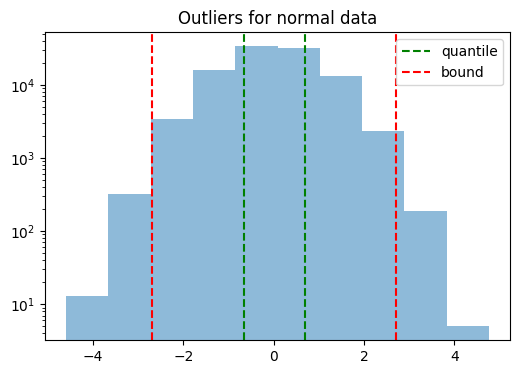

In [ ]:
plt.figure(figsize=(6,4))

norm_values = np.random.randn(100000)
q_25 = np.quantile(norm_values, 0.25)
q_75 = np.quantile(norm_values, 0.75)
IQR = q_75 - q_25
lower_bound = q_25 - 1.5 * IQR
upper_bound = q_75 + 1.5 * IQR

plt.title('Outliers for normal data')
plt.hist(norm_values, log=True, alpha=0.5)
plt.axvline(x=q_25, color='green', linestyle='--', label='quantile')
plt.axvline(x=q_75, color='green', linestyle='--')
plt.axvline(x=lower_bound, color='red', linestyle='--', label='bound')
plt.axvline(x=upper_bound, color='red', linestyle='--')
plt.legend()

Now, let's apply it to our data:

In [ ]:
X_train = handle_outliers(X_train, outlier_features, method='clip')
X_val = handle_outliers(X_val, outlier_features, method='clip')
X_test = handle_outliers(X_test, outlier_features, method='clip')

### Normalization

Linear models don't work well when different features have different scale.

**Normalization** is crucial for logistic regression because it ensures that features contribute equally to the model, prevents features with larger scales from dominating, and helps the optimization algorithm converge faster.

Note how we apply normalization:

1. Normalizer is **fitted** on training data (and we use it to **transform** the test data on the same call).
2. Normalizer **transforms** the validation and test data.

Always make sure that your tranformations are only fitted on training data. Test data shouldn't leak into the training of any transformations or models.

There are several normalizers available. We'll use `StandardScaler`, which zeroes the mean and scales variance to 1. So, that's what is does:
$$z = \frac{x - \mathrm{mean}(x)}{\mathrm{std}(x)}$$

In [ ]:
from sklearn.preprocessing import StandardScaler

num_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
    'Temp9am', 'Temp3pm']

scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Categorical Features

Let's start by identifying the categorical features in our training data. Note that `Sunshine_missing` and `Evaporation_missing` are created as numerical features (they have the `int` type).

In [ ]:
categorical_features = X_train.select_dtypes(include=['object']).columns
print("Categorical features:", categorical_features.tolist())

Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


### Checking for missing values

Next, let's check if any of our categorical features have missing values

In [ ]:
missing_categorical = X_train[categorical_features].isnull().sum()
missing_categorical = missing_categorical[missing_categorical > 0]
print("Missing  in categorical features:\n", missing_categorical)

Missing  in categorical features:
 WindGustDir    5599
WindDir9am     6013
WindDir3pm     2265
RainToday       837
dtype: int64


In [ ]:
missing_percentage = (missing_categorical / len(X_train))
print(f"""Percentage of missing values in categorical features:\n
{np.round(missing_percentage*100)}%""", )

Percentage of missing values in categorical features:

WindGustDir    7.0
WindDir9am     7.0
WindDir3pm     3.0
RainToday      1.0
dtype: float64%


To better understand the distribution of each categorical feature, let's plot histograms

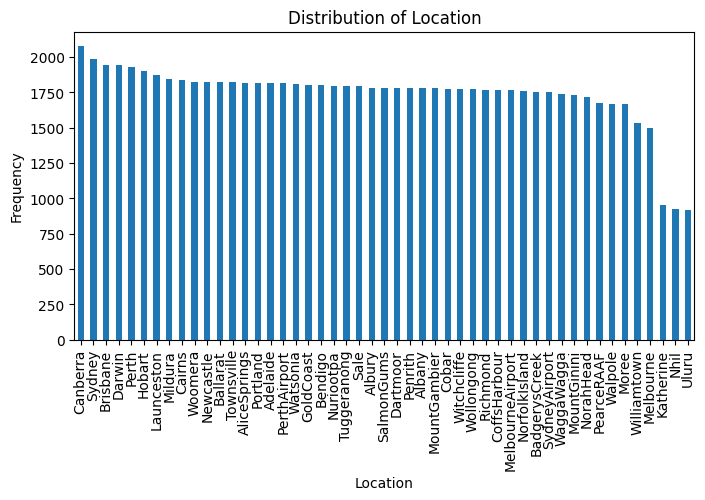

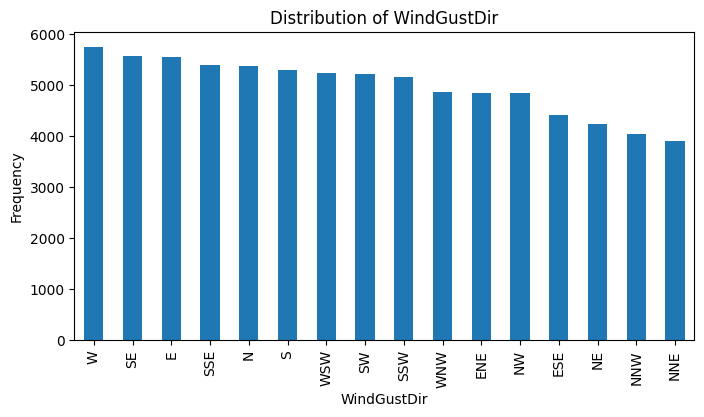

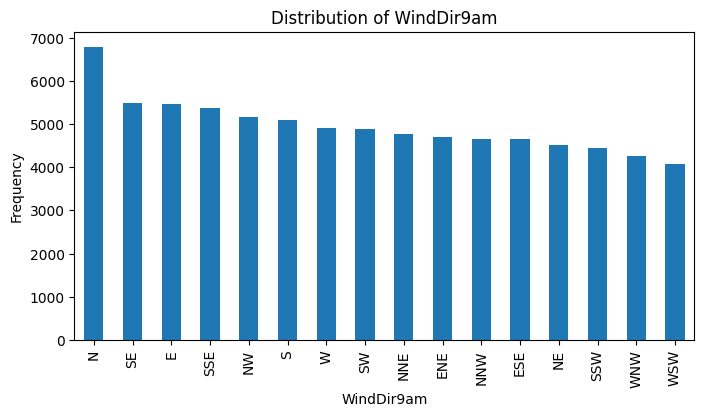

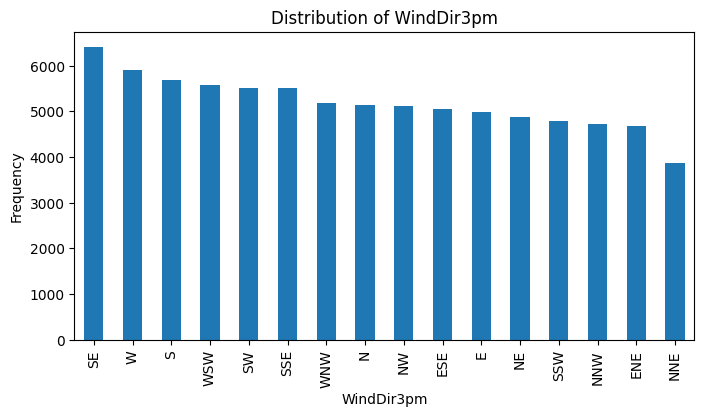

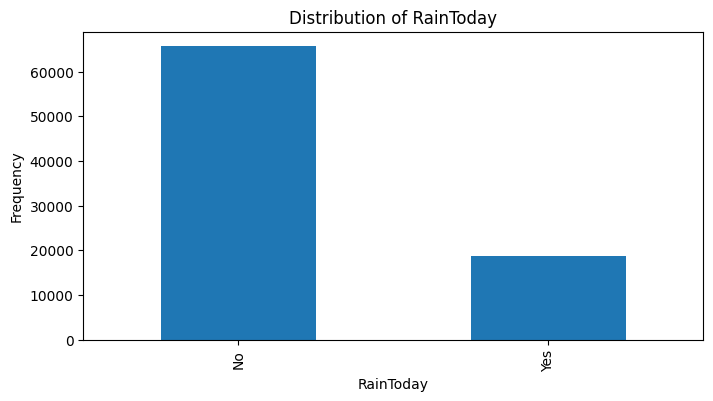

In [ ]:
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    X_train[feature].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

Now that we know where the missing values are, let’s fill them. We'll replace each missing value in a categorical feature with its most frequently occurring value. This way, we're keeping the category that’s most representative of the data. It should be ok, because we don't have too many missing values.

In [ ]:
for feature in missing_categorical.index:
    most_frequent = X_train[feature].mode()[0]
    X_train[feature].fillna(most_frequent, inplace=True)
    X_val[feature].fillna(most_frequent, inplace=True)
    X_test[feature].fillna(most_frequent, inplace=True)

print("Missing values after filling:", X_train[categorical_features].isnull().sum().sum())

Missing values after filling: 0


Filling in missing values with the most frequent category is a quick solution, but there are other options. For example, we could add a new category like ‘Unknown’ specifically for missing values, or even try to predict the missing values based on other features. Each method has its pros and cons, so the choice depends on the dataset and the specific goals

### One-Hot Encoding

To decide on our encoding method, let’s take a look at how many unique values each categorical feature has. This will help us understand the diversity of categories

In [ ]:
for feature in categorical_features:
    unique_count = X_train[feature].nunique()
    print(f"{feature}: {unique_count} unique values")

Location: 49 unique values
WindGustDir: 16 unique values
WindDir9am: 16 unique values
WindDir3pm: 16 unique values
RainToday: 2 unique values


Since our categorical features have different numbers of unique values, we'll use one-hot encoding to convert them into a numeric format. One-hot encoding will create a new column for each unique value, which allows the model to treat each category distinctly

In [ ]:
for df in [X_train, X_val, X_test]:
    df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_features = [
    'Rainfall', 'Evaporation', 'WindSpeed9am', 'WindSpeed3pm', 'Sunshine',
    'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
    'Cloud3pm', 'MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day'
]
categorical_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

binary_features = ['RainToday', 'Sunshine_missing', 'Evaporation_missing']

def one_hot_encode_data(df, numerical_features, categorical_features, binary_features):
    # Note that we drop the first of the dummy variables
    ohe_encoded = pd.get_dummies(df[categorical_features], drop_first=True)
    processed_data = pd.concat([df[numerical_features], df[binary_features], ohe_encoded], axis=1)
    return processed_data

X_train = one_hot_encode_data(X_train, numerical_features, categorical_features, binary_features)
X_val = one_hot_encode_data(X_val, numerical_features, categorical_features, binary_features)
X_test = one_hot_encode_data(X_test, numerical_features, categorical_features, binary_features)

print(f"Train shape after OHE: {X_train.shape}")
print(f"Validation shape after OHE: {X_val.shape}")
print(f"Test shape after OHE: {X_test.shape}")

Train shape after OHE: (85315, 114)
Validation shape after OHE: (28439, 114)
Test shape after OHE: (28439, 114)


# Training Linear Models


Now that our data is fully prepared, let's train a linear model to evaluate its performance.

A typical interface of an ML model in sklearn has several functions:

- `fit` **fits** a model on training data,
- `predict` makes **predictions** (target for regression, class label for classification),
- `predict_proba`, for classifiers, predicts class probabilities. We'll discuss it later.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, PrecisionRecallDisplay, f1_score, confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(solver='liblinear', random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Before checking the metrics,  let's look at the coefficients. Linear models are cool because they are interpretable in a quite straightforward way, and it's good to check how much the signs and the absolute values of the coefficient are justified by our domain understanding.

In [ ]:
for feature, coef in sorted(list(zip(X_train.columns, model.coef_[0])), key=lambda t: t[1]):
    print(f"{feature}: {coef}")

Pressure3pm: -0.9119508390312153
Location_Townsville: -0.3601841283668196
Sunshine: -0.3540590501812015
Location_Wollongong: -0.3122616508667236
Location_MountGinini: -0.27434101355690427
WindDir3pm_NE: -0.2627453807976655
Location_Darwin: -0.26180298042959066
WindDir9am_SSE: -0.24108237536117433
Location_Ballarat: -0.23098732729628502
WindGustDir_NE: -0.23025974572875377
Location_GoldCoast: -0.2047788905250193
WindDir3pm_SSE: -0.20364548017124662
Location_Hobart: -0.20034434368984955
Location_NorahHead: -0.19331926204595534
WindDir9am_S: -0.19066326905462705
Location_Launceston: -0.18464934987057485
WindDir9am_SE: -0.1822268362258891
Location_Sale: -0.18101822534693637
WindGustDir_NNE: -0.17804472219855227
WindDir9am_ESE: -0.17344505231911345
Location_MelbourneAirport: -0.1698482867300453
Location_NorfolkIsland: -0.16831244113351657
WindDir3pm_SW: -0.13264352704918783
Location_Katherine: -0.1167910438367778
WindGustDir_ENE: -0.10415929050428362
WindDir3pm_ENE: -0.09415260519518083
Loc

Now, let's explore the metrics

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Model Metrics:
Accuracy: 0.8405
Precision: 0.7021
Recall: 0.5009
F1 Score: 0.5846


 It's also helpful to look at the confusion matrix

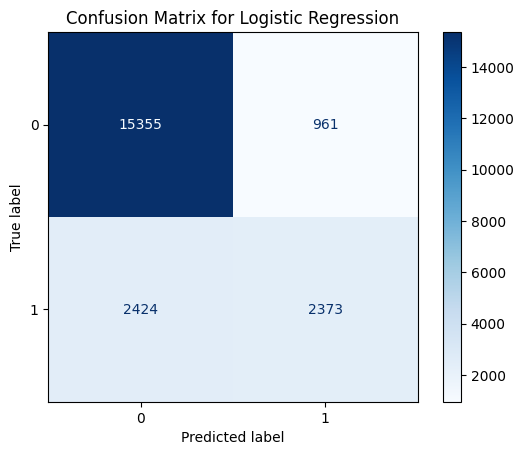

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

The confusion matrix highlights a class imbalance, with the model finding it much easier to predict "no rain" than to correctly identify instances of rain.

Sometimes, it’s useful to look at the precision-recall curve if we want to set a specific level of precision or recall. By examining this curve, we can select an optimal threshold that meets a desired balance.

Note that we can get the predicted probabilities for classes 0 and 1 by using `model.predict_proba`. It returns two numbers for each object, so model.`predict_proba(X_test)[:, 1]` gives the class 1 predicted probabilities.

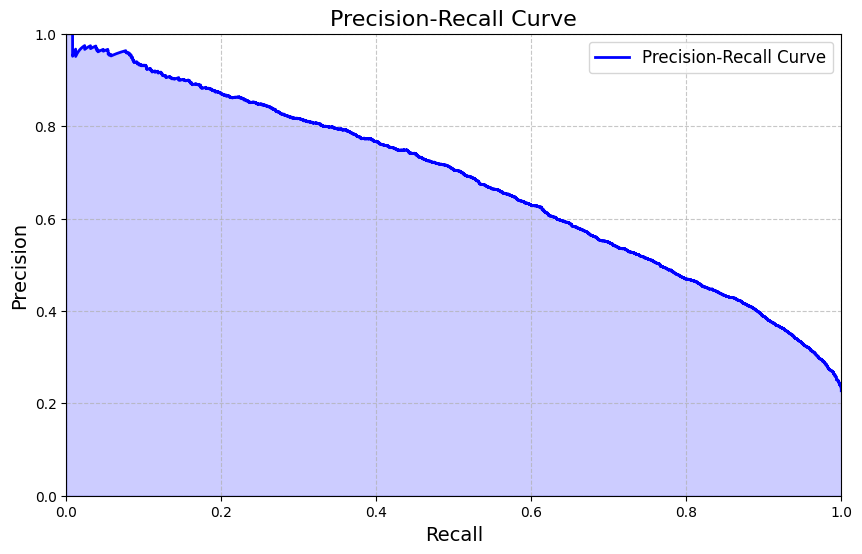

In [ ]:
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', linewidth=2, label="Precision-Recall Curve")
plt.fill_between(recall, precision, alpha=0.2, color="blue")
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="best", fontsize=12)
plt.show()

We'll also create a function that finds the threshold that maximizes recall with `Precision >= precision_target`.

In [ ]:
def find_recall_threshold(precision_target, precision, recall, thresholds):
    indices = np.where(precision >= precision_target)[0]
    if len(indices) == 0:
        raise ValueError(f"No precision values meet or exceed the target: {precision_target:.2f}")

    idx = indices[0]

    recall_for_target = recall[idx]
    eventual_precision = precision[idx]
    threshold_for_target = thresholds[idx] if idx < len(thresholds) else None
    return recall_for_target, threshold_for_target, eventual_precision

precision_target = 0.8
recall_for_target, threshold_for_target, eventual_precision = find_recall_threshold(
    precision_target, precision, recall, thresholds
)

print(f"For precision >= {precision_target:.2f}:")
print(f"  Recall: {recall_for_target:.4f}")
print(f"  Threshold: {threshold_for_target:.4f}")
print(f"  Precision: {eventual_precision:.4f}")

For precision >= 0.80:
  Recall: 0.3346
  Threshold: 0.6625
  Precision: 0.8001


Let's also look at the confusion matrix:

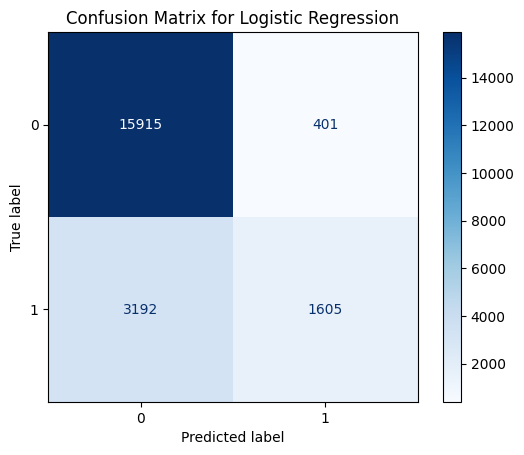

In [ ]:
y_pred_with_threshold = (y_scores >= threshold_for_target).astype(int)
cm = confusion_matrix(y_test, y_pred_with_threshold)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [ ]:
f1 = f1_score(y_test, y_pred_with_threshold)

print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4719


In [ ]:
!pip install -q dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 4.4 MB/s eta 0:00:00


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash import Dash, dcc, html
from dash.dependencies import Input, Output



# Create Dash app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Graph(id='classification-plot'),
    dcc.Slider(
        id='threshold-slider',
        min=0,
        max=1,
        step=0.01,
        value=0.5,
        marks={i/10: str(i/10) for i in range(11)}
    )
])

@app.callback(
    Output('classification-plot', 'figure'),
    Input('threshold-slider', 'value')
)
def update_figure(threshold):
    # Create figure with 1x2 subplots
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Confusion Matrix', 'Precision-Recall Curve'),
                        column_widths=[0.5, 0.5])

    # 1. Confusion Matrix
    y_pred = (model.predict_proba(X_test)[:, 1] > threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # Calculate percentages and additional metrics
    cm_percent = cm / len(y_test) * 100
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_val = 2 / ((1/precision_val) + (1/recall_val))

    annotations = [
        [f'FN: {fn}<br>({cm_percent[1,0]:.1f}%)', f'TP: {tp}<br>({cm_percent[1,1]:.1f}%)'],
        [f'TN: {tn}<br>({cm_percent[0,0]:.1f}%)', f'FP: {fp}<br>({cm_percent[0,1]:.1f}%)']
    ]

    fig.add_trace(
        go.Heatmap(
            z=cm_percent[::-1,:],
            x=['Predicted 0', 'Predicted 1'],
            y=['Actual 1', 'Actual 0'],
            text=annotations,
            texttemplate='%{text}',
            textfont={"size": 14},
            colorscale=[[0, 'white'], [1, 'navy']],  # Simple white to navy blue scale
            showscale=True,
            colorbar=dict(title='% of total')
        ),
        row=1, col=1
    )

    # Add metrics as annotations





    # 2. PR curve
    fig.add_trace(
        go.Scatter(
            x=recall,
            y=precision,
            mode='lines',
            name='PR curve'
        ),
        row=1, col=2
    )

    # Current point on PR curve
    idx = np.searchsorted(thresholds, threshold)
    if idx == len(thresholds):
        idx = -1
    fig.add_trace(
        go.Scatter(
            x=[recall[idx]],
            y=[precision[idx]],
            mode='markers',
            marker=dict(color='red', size=15),
            name='Current threshold'
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        height=600,
        width=1200,
        showlegend=True,
        title_text=f"""Classification with Threshold: {threshold:.2f}<br>
        Accuracy: {accuracy:.3f}\t Precision: {precision_val:.3f}\t Recall: {recall_val:.3f}\t F1: {f1_val:.3f}"""
    )

    # Update axes
    fig.update_xaxes(title_text="Recall", range=[0, 1], row=1, col=2)
    fig.update_yaxes(title_text="Precision", range=[0, 1], row=1, col=2)

    return fig

if __name__ == '__main__':
    app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# Feature Engineering


It can often be useful to apply logical reasoning to engineer additional features. In our case, knowing whether it is raining in nearby locations could be a valuable indicator. To determine neighboring locations, we will use an additional dataset containing geographical coordinates. We will then optimize the number of neighbors using validation data.

In [ ]:
locations_df = pd.read_csv('coords.csv')
locations_df['Location'] = locations_df['Location'].str.strip().str.title()

In [ ]:
# This part of the code is used to restore the categorical Location feature, as it was previously encoded.

location_mapping = {
    'Mountginini': 'Mount Ginini',
    'Badgeryscreek': 'Badgerys Creek',
    'Coffsharbour': 'Coffs Harbour',
    'Melbourneairport': 'Melbourne Airport',
    'Perthairport': 'Perth Airport',
    'Waggawagga': 'Wagga Wagga',
    'Mountgambier': 'Mount Gambier',
    'Norfolkisland': 'Norfolk Island',
    'Sydneyairport': 'Sydney Airport',
    'Pearceraaf': 'Pearce Raaf',
    'Alicesprings': 'Alice Springs',
    'Goldcoast': 'Gold Coast',
    'Salmongums': 'Salmon Gums',
    'Norahhead': 'Norah Head'
}

def restore_location_from_ohe(X, location_prefix='Location_'):
    location_columns = [col for col in X.columns if col.startswith(location_prefix)]
    X['Location'] = (
        X[location_columns]
        .idxmax(axis=1)
        .str.replace(location_prefix, '', regex=False)
        .str.strip()
        .str.title()
    )
    return X

X_train = restore_location_from_ohe(X_train)
X_val = restore_location_from_ohe(X_val)
X_test = restore_location_from_ohe(X_test)

X_train['Location'] = X_train['Location'].replace(location_mapping)
X_val['Location'] = X_val['Location'].replace(location_mapping)
X_test['Location'] = X_test['Location'].replace(location_mapping)

### Adding geographic neighbour information

In [ ]:
!pip install -q haversine

In [ ]:
from haversine import haversine, Unit

def find_neighbors(location, locations_df, n_neighbors=3):
    target_coords = locations_df[locations_df['Location'] == location][['Latitude', 'Longitude']].values[0]

    distances = locations_df[['Latitude', 'Longitude']].apply(
        lambda row: haversine(target_coords, (row['Latitude'], row['Longitude']), unit=Unit.KILOMETERS),
        axis=1
    )

    locations_df['Distance'] = distances
    neighbors = locations_df.sort_values(by='Distance').iloc[1:n_neighbors+1]['Location'].tolist()

    return neighbors

In [ ]:
def add_count_neighbor_rain_feature(X, locations_df, n_neighbors):
    neighbor_features = pd.DataFrame(index=X.index)

    for location in locations_df['Location']:
        neighbors = find_neighbors(location, locations_df, n_neighbors)
        location_mask = X['Location'] == location

        neighbor_rain_count = X.loc[X['Location'].isin(neighbors), 'RainToday'].sum()
        neighbor_features.loc[location_mask, 'Neighbor_RainToday_Count'] = neighbor_rain_count

    neighbor_features['Neighbor_RainToday_Count'].fillna(0, inplace=True)

    return pd.concat([X, neighbor_features], axis=1)

def remove_location(X):
    return X.drop(columns=['Location'], errors='ignore')

In [ ]:
print("\nBaseline model without neighbors...")
base_features = [col for col in X_train.columns if col not in ['RainToday', 'Location']]
model_baseline = LogisticRegression(solver='liblinear', random_state=42)
model_baseline.fit(remove_location(X_train[base_features]), y_train)

y_val_pred_baseline = model_baseline.predict(remove_location(X_val[base_features]))
f1_baseline = f1_score(y_val, y_val_pred_baseline)
print(f"Baseline F1 Score (no neighbors): {f1_baseline:.4f}")

neighbor_counts = list(range(1, 16))
best_neighbors = None
best_f1 = f1_baseline

for n_neighbors in neighbor_counts:
    print(f"\nTesting with {n_neighbors} neighbors...")

    X_train_neighbors = add_count_neighbor_rain_feature(X_train, locations_df, n_neighbors)
    X_val_neighbors = add_count_neighbor_rain_feature(X_val, locations_df, n_neighbors)

    X_train_clean = remove_location(X_train_neighbors)
    X_val_clean = remove_location(X_val_neighbors)

    features = [col for col in X_train_clean.columns if col not in ['RainToday', 'Location']]
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train_clean[features], y_train)

    y_val_pred = model.predict(X_val_clean[features])
    f1_val = f1_score(y_val, y_val_pred)
    print(f"F1 Score with {n_neighbors} neighbors: {f1_val:.4f}")

    if f1_val > best_f1:
        best_f1 = f1_val
        best_neighbors = n_neighbors

if best_neighbors:
    print(f"Best number of neighbors: {best_neighbors} with F1 Score: {best_f1:.4f}")

if best_neighbors:
    X_train_neighbors = add_count_neighbor_rain_feature(X_train, locations_df, best_neighbors)
    X_test_neighbors = add_count_neighbor_rain_feature(X_test, locations_df, best_neighbors)

    X_train_clean = remove_location(X_train_neighbors)
    X_test_clean = remove_location(X_test_neighbors)

    features = [col for col in X_train_clean.columns if col not in ['RainToday', 'Location']]
    final_model = LogisticRegression(solver='liblinear', random_state=42)
    final_model.fit(X_train_clean[features], y_train)

    y_test_pred = final_model.predict(X_test_clean[features])
    f1_test = f1_score(y_test, y_test_pred)
    print(f"\nFinal Test F1 Score with {best_neighbors} neighbors: {f1_test:.4f}")
else:
    print("No improvement over baseline was observed.")


Baseline model without neighbors...
Baseline F1 Score (no neighbors): 0.5847

Testing with 1 neighbors...
F1 Score with 1 neighbors: 0.5946

Testing with 2 neighbors...
F1 Score with 2 neighbors: 0.5862

Testing with 3 neighbors...
F1 Score with 3 neighbors: 0.5920

Testing with 4 neighbors...
F1 Score with 4 neighbors: 0.6008

Testing with 5 neighbors...
F1 Score with 5 neighbors: 0.5800

Testing with 6 neighbors...
F1 Score with 6 neighbors: 0.5956

Testing with 7 neighbors...
F1 Score with 7 neighbors: 0.5764

Testing with 8 neighbors...
F1 Score with 8 neighbors: 0.5685

Testing with 9 neighbors...
F1 Score with 9 neighbors: 0.5678

Testing with 10 neighbors...
F1 Score with 10 neighbors: 0.5813

Testing with 11 neighbors...
F1 Score with 11 neighbors: 0.5536

Testing with 12 neighbors...
F1 Score with 12 neighbors: 0.5466

Testing with 13 neighbors...
F1 Score with 13 neighbors: 0.5623

Testing with 14 neighbors...
F1 Score with 14 neighbors: 0.4844

Testing with 15 neighbors...


## Adding polynomial features

Let's try generating additional polynomial features and combining them with the optimal number of neighbors

In [ ]:
# This part of the code is used to restore the categorical Location feature, as it was previously encoded.

location_mapping = {
    'Mountginini': 'Mount Ginini',
    'Badgeryscreek': 'Badgerys Creek',
    'Coffsharbour': 'Coffs Harbour',
    'Melbourneairport': 'Melbourne Airport',
    'Perthairport': 'Perth Airport',
    'Waggawagga': 'Wagga Wagga',
    'Mountgambier': 'Mount Gambier',
    'Norfolkisland': 'Norfolk Island',
    'Sydneyairport': 'Sydney Airport',
    'Pearceraaf': 'Pearce Raaf',
    'Alicesprings': 'Alice Springs',
    'Goldcoast': 'Gold Coast',
    'Salmongums': 'Salmon Gums',
    'Norahhead': 'Norah Head'
}

def restore_location_from_ohe(X, location_prefix='Location_'):
    location_columns = [col for col in X.columns if col.startswith(location_prefix)]
    X['Location'] = (
        X[location_columns]
        .idxmax(axis=1)
        .str.replace(location_prefix, '', regex=False)
        .str.strip()
        .str.title()
    )
    return X

X_train = restore_location_from_ohe(X_train)
X_val = restore_location_from_ohe(X_val)
X_test = restore_location_from_ohe(X_test)

X_train['Location'] = X_train['Location'].replace(location_mapping)
X_val['Location'] = X_val['Location'].replace(location_mapping)
X_test['Location'] = X_test['Location'].replace(location_mapping)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def generate_polynomial_features(X, degree=2, interaction_only=False):
    numeric_features = ['Rainfall', 'Evaporation', 'WindSpeed9am', 'WindSpeed3pm',
                        'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                        'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'MinTemp', 'MaxTemp',
                        'Temp9am', 'Temp3pm']

    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    X_numeric = X[numeric_features]
    X_poly = poly.fit_transform(X_numeric)
    poly_feature_names = poly.get_feature_names_out(numeric_features)

    X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)
    return pd.concat([X, X_poly_df], axis=1)

In [ ]:
print("\nBaseline model without neighbors or polynomial features...")
features_baseline = [col for col in X_train.columns if col not in ['RainToday', 'Location']]
model_baseline = LogisticRegression(solver='liblinear', random_state=42)
model_baseline.fit(X_train[features_baseline], y_train)
y_test_pred_baseline = model_baseline.predict(X_test[features_baseline])
f1_baseline = f1_score(y_test, y_test_pred_baseline)
print(f"Baseline F1 Score: {f1_baseline:.4f}")

print("\nModel with 10 neighbors...")
X_train_neighbors = add_count_neighbor_rain_feature(X_train, locations_df, 10)
X_test_neighbors = add_count_neighbor_rain_feature(X_test, locations_df, 10)
features_neighbors = [col for col in X_train_neighbors.columns if col not in ['RainToday', 'Location']]
model_neighbors = LogisticRegression(solver='liblinear', random_state=42)
model_neighbors.fit(X_train_neighbors[features_neighbors], y_train)
y_test_pred_neighbors = model_neighbors.predict(X_test_neighbors[features_neighbors])
f1_neighbors = f1_score(y_test, y_test_pred_neighbors)
print(f"F1 Score with 10 neighbors: {f1_neighbors:.4f}")

print("\nModel with polynomial features...")
X_train_poly = generate_polynomial_features(X_train, degree=2)
X_test_poly = generate_polynomial_features(X_test, degree=2)
features_poly = [col for col in X_train_poly.columns if col not in ['RainToday', 'Location']]
model_poly = LogisticRegression(solver='liblinear', random_state=42)
model_poly.fit(X_train_poly[features_poly], y_train)
y_test_pred_poly = model_poly.predict(X_test_poly[features_poly])
f1_poly = f1_score(y_test, y_test_pred_poly)
print(f"F1 Score with polynomial features: {f1_poly:.4f}")

print("\nModel with polynomial features and 10 neighbors...")
X_train_poly_neighbors = add_count_neighbor_rain_feature(X_train_poly, locations_df, 10)
X_test_poly_neighbors = add_count_neighbor_rain_feature(X_test_poly, locations_df, 10)
features_poly_neighbors = [col for col in X_train_poly_neighbors.columns if col not in ['RainToday', 'Location']]
model_poly_neighbors = LogisticRegression(solver='liblinear', random_state=42)
model_poly_neighbors.fit(X_train_poly_neighbors[features_poly_neighbors], y_train)
y_test_pred_poly_neighbors = model_poly_neighbors.predict(X_test_poly_neighbors[features_poly_neighbors])
f1_poly_neighbors = f1_score(y_test, y_test_pred_poly_neighbors)
print(f"F1 Score with polynomial features and 10 neighbors: {f1_poly_neighbors:.4f}")


Baseline model without neighbors or polynomial features...
Baseline F1 Score: 0.5846

Model with 10 neighbors...
F1 Score with 10 neighbors: 0.5825

Model with polynomial features...
F1 Score with polynomial features: 0.6024

Model with polynomial features and 10 neighbors...
F1 Score with polynomial features and 10 neighbors: 0.5999


We successfully improved the metrics by generating new features!

# Decision Boundaries and Probabilities

To understand how linear models separate classes, let's start by generating a simple 2D dataset. We'll use a dataset shaped like two interlocking moons, which will allow us to visualize decision boundaries clearly

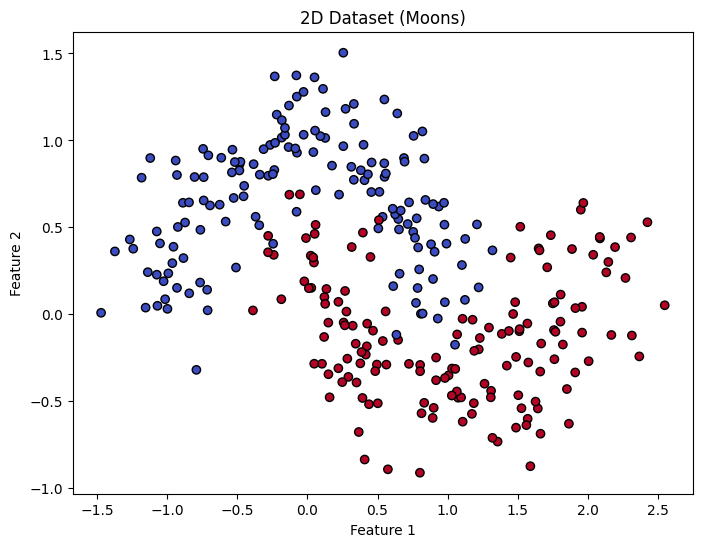

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k")
plt.title("2D Dataset (Moons)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Now, let's train a logistic regression model on our dataset. This will help us understand how well it separates

In [ ]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

To see how our model is classifying points, let's plot the decision boundary. We'll also display the probability that each area belongs to one of the classes, so we can get a sense of the model’s confidence in its predictions

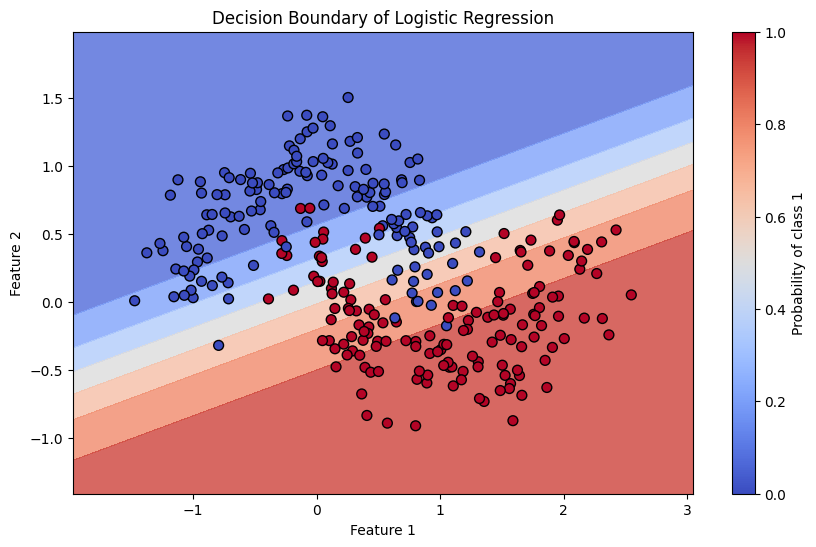

In [ ]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=50)
plt.colorbar(label="Probability of class 1")
plt.title("Decision Boundary of Logistic Regression")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

To verify if the predicted probabilities match the actual distribution of classes around certain points, we’ll select a few sample points. For each point, we’ll look at the nearby data points (within a specific radius) and calculate the actual ratio of class 1 in that area

Point: [0.  0.5]
Predicted Probability of Class 1: 0.18
Actual Ratio of Class 1 in Neighborhood: 0.71

Point: [ 1.  -0.5]
Predicted Probability of Class 1: 0.97
Actual Ratio of Class 1 in Neighborhood: 1.00

Point: [1.5 0.5]
Predicted Probability of Class 1: 0.59
Actual Ratio of Class 1 in Neighborhood: 0.71



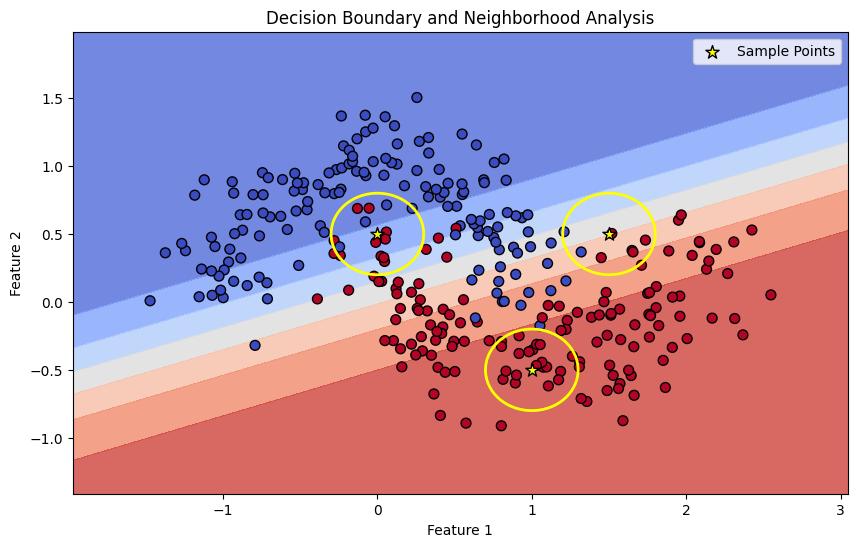

In [ ]:
from sklearn.neighbors import NearestNeighbors

sample_points = np.array([[0, 0.5], [1, -0.5], [1.5, 0.5]])
radius = 0.3

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=50)
plt.scatter(sample_points[:, 0], sample_points[:, 1], c='yellow', edgecolor="k", s=100, marker="*", label="Sample Points")

nbrs = NearestNeighbors(radius=radius).fit(X)
for point in sample_points:
    indices = nbrs.radius_neighbors([point], return_distance=False)[0]
    local_points = X[indices]
    local_labels = y[indices]

    actual_ratio = np.mean(local_labels)
    predicted_proba = model.predict_proba([point])[0, 1]

    print(f"Point: {point}")
    print(f"Predicted Probability of Class 1: {predicted_proba:.2f}")
    print(f"Actual Ratio of Class 1 in Neighborhood: {actual_ratio:.2f}\n")

    circle = plt.Circle(point, radius, color="yellow", fill=False, linewidth=2)
    plt.gca().add_artist(circle)

plt.title("Decision Boundary and Neighborhood Analysis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

Our model’s decision boundary separates the two classes, but it's not always perfect, especially near the boundary itself

Let's train SVM with an RBF kernel. This kernel suits non-linear data by creating flexible class boundaries.

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X, y)

Z_svm = svm_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z_svm = Z_svm.reshape(xx.shape)

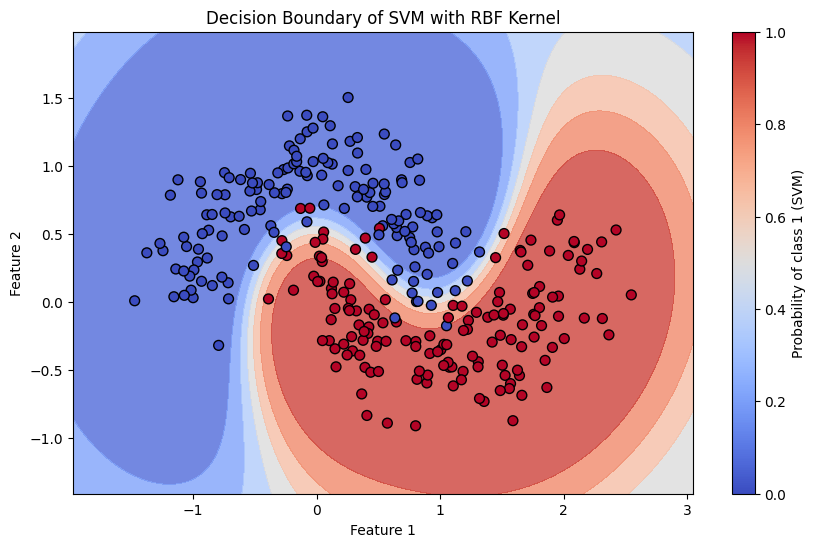

In [ ]:
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_svm, cmap="coolwarm", alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=50)
plt.colorbar(label="Probability of class 1 (SVM)")
plt.title("Decision Boundary of SVM with RBF Kernel")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

SVM - Point: [0.  0.5]
Predicted Probability of Class 1: 0.60
Actual Ratio of Class 1 in Neighborhood: 0.71

SVM - Point: [ 1.  -0.5]
Predicted Probability of Class 1: 0.99
Actual Ratio of Class 1 in Neighborhood: 1.00

SVM - Point: [1.5 0.5]
Predicted Probability of Class 1: 0.55
Actual Ratio of Class 1 in Neighborhood: 0.71



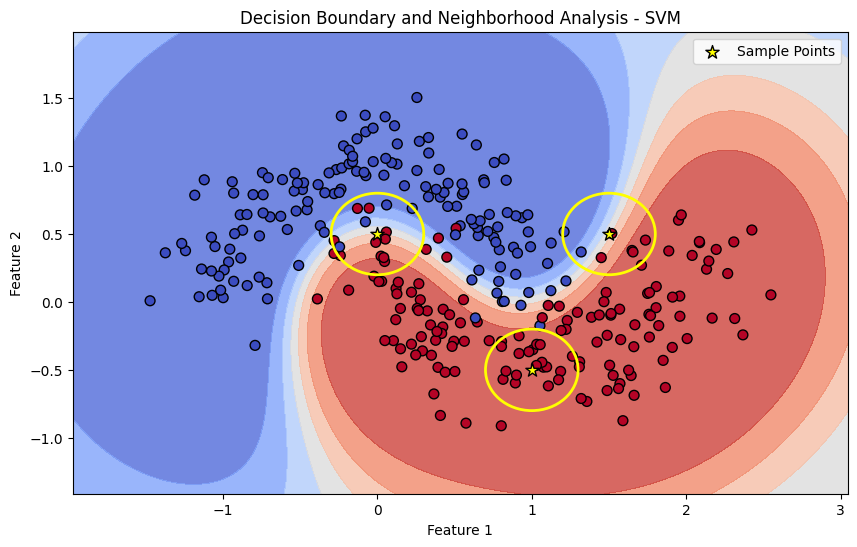

In [ ]:
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z_svm, cmap="coolwarm", alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=50)
plt.scatter(sample_points[:, 0], sample_points[:, 1], c='yellow', edgecolor="k", s=100, marker="*", label="Sample Points")

for point in sample_points:
    indices = nbrs.radius_neighbors([point], return_distance=False)[0]
    local_points = X[indices]
    local_labels = y[indices]

    actual_ratio = np.mean(local_labels)
    predicted_proba_svm = svm_model.predict_proba([point])[0, 1]

    print(f"SVM - Point: {point}")
    print(f"Predicted Probability of Class 1: {predicted_proba_svm:.2f}")
    print(f"Actual Ratio of Class 1 in Neighborhood: {actual_ratio:.2f}\n")

    circle = plt.Circle(point, radius, color="yellow", fill=False, linewidth=2)
    plt.gca().add_artist(circle)

plt.title("Decision Boundary and Neighborhood Analysis - SVM")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The decision boundaries are smoother and more accurately fit the data shape, improving prediction confidence